# PCR, PLS, Ridge et Lasso

- *Auteurs:* Quentin Grimonprez, Cristian Preda, Vincent Vandewalle
- *Date:* 22 février 2020

## Objectif du TP

L'objectif de ce TP est de présenter des solutions pour réaliser la régression linéaire en condition de multicolinéarité. On utilisera le package scikit-learn. Nous allons illustrer les principales fonctionnalités de ces fonctions à l’aide de la base de données disponible à l’adresse : <http://math.univ-lille1.fr/∼preda/GIS4/car.txt>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = 12, 8

## Aperçu des données

Chargement des données car à partir du fichier fourni. En ouvrant ce fichier, on notera que les séparateur est la tabulation et que la 1ère colonne correspond aux index, et la 1ère ligne aux noms de colonnes.

In [5]:
car = pd.read_table("data/car.txt", sep="\t", header=0, index_col=0)
car.head()

,CYL,PUIS,LON,LAR,POIDS,VITESSE,NAT,FINITION,PRIX
NOM,,,,,,,,,
ALFASUD-TI-1350,1350,79,393,161,870,165,I,B,30570
AUDI-100-L,1588,85,468,177,1110,160,D,TB,39990
SIMCA-1307-GLS,1294,68,424,168,1050,152,F,M,29600
CITROEN-GS-CLUB,1222,59,412,161,930,151,F,M,28250
FIAT-132-1600GLS,1585,98,439,164,1105,165,I,B,34900


On vérifie le type des colonnes. Les chaînes de caractères sont de type *object*.

In [7]:
car.dtypes

CYL          int64
PUIS         int64
LON          int64
LAR          int64
POIDS        int64
VITESSE      int64
NAT         object
FINITION    object
PRIX         int64
dtype: object

#### Statistiques univariées

In [9]:
print(car.shape)
car.describe(percentiles=[0.1, 0.5, 0.9], include="all")

(18, 9)


,CYL,PUIS,LON,LAR,POIDS,VITESSE,NAT,FINITION,PRIX
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18,18,18.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,6,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,F,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,6,7,NaN
mean,1631.666667,84.611111,433.500000,166.666667,1078.833333,158.277778,NaN,NaN,34158.611111
std,373.929846,20.376281,22.107358,5.313689,136.957808,12.140383,NaN,NaN,6571.577795
min,1166.000000,55.000000,393.000000,157.000000,815.000000,140.000000,NaN,NaN,22100.000000
10%,1272.400000,57.800000,402.500000,161.000000,912.000000,140.000000,NaN,NaN,27492.000000
50%,1577.500000,82.000000,434.500000,167.000000,1087.500000,160.000000,NaN,NaN,33345.000000
90%,1994.500000,110.800000,461.700000,173.000000,1208.000000,173.600000,NaN,NaN,42870.500000


La valeur **count** représentent le nombre de données présentes. On constate qu'il n'y a pas de manquants.

## Expliquer/prédire le PRIX des voitures à partir de leurs caractéristiques

Note : Les variables qualitatives (ici *NAT* et *FINITION*) ne peuvent pas faire partie d'un modèle de régression basé sur les composantes principales ou PLS car ces techniques ne sont pas adaptées à ce type de données. Par contre Ridge et Lasso traitent aussi bien les variables qualitatives que les variables quantitatives. On ne va donc considérer dans la liste des prédicteurs que les variables **quantitatives**.

On sépare le jeu de données en X et y pour suivre l'[API de scikit-learn](https://scikit-learn.org/stable/modules/classes.html). Scikit-learn est fait pour fonctionner avec des numpy.array ou équivalents, on ne pourra pas utiliser de formules comme dans statsmodels ou R. La force de scikit-learn est que toutes les méthodes partageant le même but (ex: prédiction) ont la même API, c'est-à-dire même noms de paramètres, même noms de méthodes. Toutes les méthodes de régressions que nous utilisons dans la suite ont une méthode `fit` qui prend en paramètres X et y, une méthode `predict`... C'est cela qui fait la force de scikit-learn en permettant de changer de modèle facilement. Par contre, elle ne dispose pas d'analyse statistique des résultats à l'inverse de statsmodels.

In [11]:
X = car.iloc[:, 0:6]  # .iloc permet d'accéder aux lignes et aux colonnes d'un DataFrame par leur position.
y = car.loc[:, "PRIX"]  # .loc permet d'accéder aux lignes et aux colonnes via leurs noms.
n, p = X.shape
X.head()

,CYL,PUIS,LON,LAR,POIDS,VITESSE
NOM,,,,,,
ALFASUD-TI-1350,1350,79,393,161,870,165
AUDI-100-L,1588,85,468,177,1110,160
SIMCA-1307-GLS,1294,68,424,168,1050,152
CITROEN-GS-CLUB,1222,59,412,161,930,151
FIAT-132-1600GLS,1585,98,439,164,1105,165


In [15]:
y.head()

NOM
ALFASUD-TI-1350     30570
AUDI-100-L          39990
SIMCA-1307-GLS      29600
CITROEN-GS-CLUB     28250
FIAT-132-1600GLS    34900
Name: PRIX, dtype: int64

On note que y est de type **Series**, c'est un **Dataframe** avec une seule colonne.

In [17]:
type(y)

pandas.core.series.Series

### Régression linéaire "ordinaire"

In [21]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [24]:
lm.coef_

array([  -3.50518169,  282.16880257,  -15.03766027,  208.69377328,
         12.57467832, -111.11355103])

On accède aux coefficients estimés par les attributs `coef_` et `intercept_`. On note que malgré le fait que nous avons fourni un DataFrame (avec des noms de colonnes), nous n'avons pas l'information sur les noms pour les coefficients.

In [27]:
pd.DataFrame([lm.coef_], columns=X.columns)

,CYL,PUIS,LON,LAR,POIDS,VITESSE
0,-3.505182,282.168803,-15.03766,208.693773,12.574678,-111.113551


In [30]:
lm.intercept_

-8239.362677061443

On peut obtenir le R2 avec la méthode `score`

In [32]:
lm.score(X, y)

0.7091028079636772

In [35]:
yhat = lm.predict(X)

In [37]:
yhat

array([29616.10867236, 36259.65464946, 31411.14922499, 26445.75074645,
       37042.99657626, 34972.83432923, 33749.14462282, 26579.9571656 ,
       44445.57655539, 24650.24125571, 38270.46181151, 34830.41842394,
       44872.42274919, 36343.488685  , 35638.06479235, 32233.42043584,
       37103.49511476, 30389.81418915])

In [42]:
mean_squared_error(y, yhat)

11864658.772722948

On effectue le même calcul avec statsmodels pour voir la différence.

In [45]:
X2 = sm.add_constant(X)
lm2 = sm.OLS(y, X2)
results = lm2.fit()
results.summary()

/home/quentin/.local/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PRIX   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     4.469
Date:                Sun, 05 Sep 2021   Prob (F-statistic):             0.0156
Time:                        16:29:11   Log-Likelihood:                -172.14
No. Observations:                  18   AIC:                             358.3
Df Residuals:                      11   BIC:                             364.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8239.3627   4.27e+04     -0.193      0.851   -1.02e+05    8.58e+04
CYL           -3.5052      5.551     -0.631      0.541     -15.722       8.712
PUIS         282.1688    174.883      1.613      0.135    -102.746     667.084
LON          -15.0377    129.747     -0.116      0.910    -300.610     270.535
LAR          208.6938    412.048      0.506      0.623    -698.218    1115.605
POIDS         12.5747     24.622      0.511      0.620     -41.618      66.768
VITESSE     -111.1136    222.257     -0.500      0.627    -600.297     378.070
==============================================================================
Omnibus:                        1.348   Durbin-Watson:                   1.262
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                0.796
Skew:                          -0.509   Prob(JB):                        0.672
Kurtosis:                       2.836   Cond. No.                     8.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Malgré un bon R2 et un test global de Fisher nous indiquant que le modèle explique le PRIX de manière significative (p = 0.0156) mieux que le modèle null (sans variables explicatives), aucune variable n'est significative ! L'explication peut venir d'une inflation de la variance des estimateurs due soit au fait que le nombre d'observations est plus petit que le nombre de variables (ce n'est pas le cas ici), soit au fait que
la matrice (X.T X) est mal-conditionnée (son inverse n’existe pas ou a des valeurs trop grandes) et dans ce dernier cas on parle de multicolinéarité : une ou plusieurs variables prédicteurs sont redondantes dans l'analyse.

statsmodels a détecté la multicolinéarité en calculant le *condition number*, c'est la racine carrée du ratio entre la plus grande et la plus petite valeur propre de X.T * X. Plus ce nombre est élevé, plus la matrice est mal conditionnée. Une valeur au-dessus de 20 est indicative d'un problème, dans notre cas, c'est au-dessus de 80000 !

### Diagnostiquer la multicolinéarité.

On réalise une ACP (normée en général) afin d’identifier des valeurs propres proches de 0.

In [48]:
scaler = StandardScaler(with_mean=False, with_std=True)
scaler.fit(X)
X_scaled = scaler.transform(X)

In [51]:
pca = PCA(n_components=p)
pca.fit(X_scaled)

PCA(n_components=6)

In [54]:
pca.explained_variance_

array([4.68090853, 0.90641889, 0.39501114, 0.22650574, 0.09826011,
       0.04583676])

In [57]:
pca.explained_variance_ratio_

array([0.73680968, 0.14267705, 0.06217768, 0.03565368, 0.01546687,
       0.00721505])

Effectivement, les deux dernières valeurs propres sont particulièrement proches de 0 et elles expliquent des quantités négligeables d’information (1.54% et 0.72%). Multicolinéarité en vue !

Une autre manière de diagnostiquer la multicolinéarité et d’investiguer la statistique VIF (Variance Inflation Factor) qui pour chaque variable prédicteur X_i∈{X1,..., X_p} calcule la quantité 1/(1-R_i^2) où R_i^2) est le R^2 (le pouvoir explicatif donc) de la variable X_i par les autres variables {X_1,..., X_i−1 , X_i+1,..., X_p}. Une valeur de VIF supérieure à 10 évoque une quasi-certitude sur la présence de multicolinéarité. Voir aussi : <https://en.wikipedia.org/wiki/Variance_inflation_factor>


In [60]:
def VIF(X):
    vif = pd.Series(index=X.columns, dtype=np.float64)
    for i in range(X.shape[1]):
        lm = LinearRegression().fit(X.drop(columns=X.columns[i]), X.iloc[:, i])
        r2 = lm.score(X.drop(columns=X.columns[i]), X.iloc[:, i])
        vif[X.columns[i]] = 1 / (1 - r2)
    return vif

In [63]:
VIF(X)

CYL         3.772014
PUIS       11.118820
LON         7.204195
LAR         4.197605
POIDS       9.957283
VITESSE     6.375112
dtype: float64

In [66]:
r2_score(y, yhat)

0.7091028079636772

On observe ici la variable PUIS avec un VIF égal à 11.11 mais aussi la variable POIDS avec un VIF = 9.95.
Il n'y a donc pas de doute que la multicolinéarité est présente.

### Solutions à la multicolinéarité: sélection stepwise, PCR, PLS, Ridge et Lasso

#### Sélection stepwise

C’est la solution la plus simple : choisir un modèle de taille plus petite qui inclut juste les variables qui ajustent le mieux les données en termes de vraisemblance pénalisée (critère AIC : voir cours régression linéaire)

Scikit-learn contient une fonction pour faire de la [sélection séquentielle](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) mais son défaut est de devoir fixer le nombre de variables à garder à l'avance. Le critère de sélection doit être un *scorer* donc impossible de mettre une critère type AIC impliquant la complexité du modèle.
On code donc notre propre fonction stepAIC.

In [69]:
def compute_AIC(n, mse, n_params):
    return n * np.log(mse) + 2 * n_params


def find_best_estimator(X, y, kept_variables, remaining_variables):
    aic = dict()
    for i in remaining_variables:
        current_variables = list(kept_variables) + [i]
        lm = LinearRegression().fit(X[:, current_variables], y)
        yhat = lm.predict(X[:, current_variables])
        mse = mean_squared_error(y, yhat)

        aic[i] = compute_AIC(len(y), mse, len(current_variables) + 1)

    best_var = min(aic.items(), key=operator.itemgetter(1))[0]
    best_AIC = aic[best_var]

    return best_AIC, best_var


def stepAIC(X, y):
    n, p = X.shape
    if isinstance(X, pd.DataFrame):
        X = X.values

    mse_null = mean_squared_error(y, np.full((n, ), y.mean()))
    aic_null = compute_AIC(len(y), mse_null, 1)

    best_AIC = aic_null
    current_AIC = 0
    kept_variables = set()
    remaining_variables = set(range(p))
    for i in range(1, p + 1):
        current_AIC, current_var = find_best_estimator(X, y, kept_variables, remaining_variables)

        if best_AIC < current_AIC:
            break
        else:
            best_AIC = current_AIC
            kept_variables.add(current_var)
            remaining_variables.remove(current_var)

    return list(kept_variables)

In [72]:
var_to_keep = stepAIC(X, y)
X.columns[var_to_keep]

Index(['PUIS', 'POIDS'], dtype='object')

In [75]:
var_to_keep

[1, 4]

In [80]:
step = LinearRegression()
step.fit(X.iloc[:, var_to_keep], y)

LinearRegression()

In [83]:
step.coef_

array([172.96722456,  16.451161  ])

In [89]:
step.intercept_

1775.6012014028092

On calcule le RMSEP pour le modèle stepwise par leave-one-out. Pour cela, on utilise la fonction cross_val_score qui permet d'appliquer une méthode de validation croisée à n'importe quel estimateur. Le paramètre scoring permet de spécifier la grandeur à calculer, la liste des scores disponibles : <https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter>. Pour le paramètre cv, on met un entier correspondant au nombre de folds pour une validation croisée K-folds. On peut préciser d'autres méthodes de validation croisée en fournissant une instance de la [méthode désirée](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

In [93]:
out = cross_validate(LinearRegression(), X.iloc[:, var_to_keep], y, cv=n, scoring="neg_root_mean_squared_error")
out

{'fit_time': array([0.00227427, 0.0022521 , 0.00197601, 0.0017767 , 0.00178599,
        0.00180078, 0.0017426 , 0.00173116, 0.00178862, 0.00175571,
        0.00172591, 0.0017302 , 0.00183892, 0.00184226, 0.00201893,
        0.00201678, 0.00192165, 0.00198078]),
 'score_time': array([0.00159645, 0.00150204, 0.00149632, 0.0012877 , 0.00126719,
        0.001333  , 0.00123596, 0.00124311, 0.00127506, 0.0013032 ,
        0.00122857, 0.00125432, 0.00133157, 0.00129175, 0.00126362,
        0.00178003, 0.00142908, 0.00138927]),
 'test_score': array([-1176.51399646, -5598.59666164, -1374.53207836, -1141.82263195,
        -2214.7862879 , -1862.08366917, -2620.80163224, -5336.41005041,
        -3064.02411106, -2538.9481773 , -6159.62991976, -1201.55892258,
         -332.74083292, -1677.66070367, -5847.77944456, -6647.75573941,
        -5330.88357943, -7994.01742724])}

In [97]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=2, scoring="neg_root_mean_squared_error", cv=n)
sfs.fit(X, y)

SequentialFeatureSelector(cv=18, estimator=LinearRegression(),
                          n_features_to_select=2,
                          scoring='neg_root_mean_squared_error')

In [102]:
X.columns[sfs.get_support()]

Index(['PUIS', 'VITESSE'], dtype='object')

La fonction ne retourne le score calculé sur chaque fold. Pour obtenir le RMSSEP, on moyenne les résultats.

In [107]:
-out["test_score"].mean()

3451.1414370032926

#### PCR

Utile lorsqu'on veut construire un modèle avec toutes les variables !

La fonction PCR n'existe pas dans scikit-learn mais peut être définie à l'aide de la fonction [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) qui permet de créer une chaine de traitement contenant des transformateurs et finissant par un estimateur. Ici pour la PCR, on réduit les données, puis on fait une ACP et finalement nous appliquons une régression linéaire.

In [112]:
pcr = {}
error_test_pcr = {}
error_train_pcr = {}
for n_comp in np.arange(1, p + 1):
    pcr[n_comp] = make_pipeline(StandardScaler(with_mean=False, with_std=True), PCA(n_components=n_comp), LinearRegression())
    cv = cross_validate(pcr[n_comp], X, y, scoring="neg_root_mean_squared_error", cv=n, return_train_score=True)
    error_test_pcr[n_comp] = -np.mean(cv["test_score"])
    error_train_pcr[n_comp] = -np.mean(cv["train_score"])

In [116]:
error_test_pcr

{1: 3725.7227578332586,
 2: 3874.5649175175154,
 3: 4200.86871041654,
 4: 4316.786518995186,
 5: 4554.929351749855,
 6: 5107.418051126646}

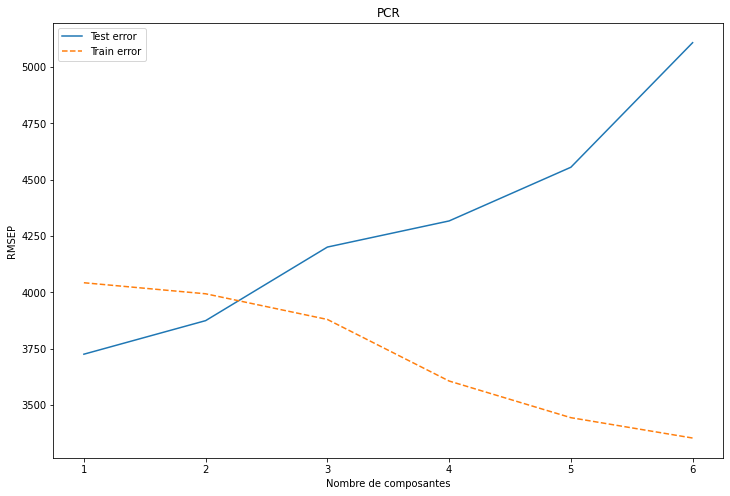

In [121]:
plt.plot(error_test_pcr.keys(), error_test_pcr.values(), label="Test error")
plt.plot(error_train_pcr.keys(), error_train_pcr.values(), ls="--", label="Train error")
plt.xlabel("Nombre de composantes")
plt.ylabel("RMSEP")
plt.title("PCR")
plt.legend()
plt.show()

Le critère est minimal (3725.72) pour 1 composante. On apprend désormais le modèle.

In [125]:
n_comp = 1
pcr[n_comp].fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components=1)),
                ('linearregression', LinearRegression())])

Coefficients de la régression PCR sur données centrées :

In [131]:
pcr[n_comp].named_steps["linearregression"].coef_

array([2346.33027554])

In [135]:
(pcr[n_comp].named_steps["linearregression"].coef_ * pcr[n_comp].named_steps["pca"].components_)

array([[ 997.04025644,  989.66899306,  988.88419572,  907.84736568,
        1010.12329822,  842.20181881]])

Coefficients de la régression PCR sur données d'origine :

In [140]:
(pcr[n_comp].named_steps["linearregression"].coef_ * pcr[n_comp].named_steps["pca"].components_) / pcr[n_comp].named_steps["standardscaler"].scale_

array([[  2.74368567,  49.97776646,  46.02781687, 175.80388641,
          7.58925916,  71.38313123]])

In [145]:
pcr[n_comp].named_steps["linearregression"].intercept_

34158.61111111111

#### Régression PLS

In [151]:
pls = {}
error_test_pls = {}
error_train_pls = {}
for n_comp in np.arange(1, p + 1):
    pls[n_comp] = PLSRegression(n_components=n_comp)
    cv = cross_validate(pls[n_comp], X, y, scoring="neg_root_mean_squared_error", cv=n, return_train_score=True)
    error_test_pls[n_comp] = -np.mean(cv["test_score"])
    error_train_pls[n_comp] = -np.mean(cv["train_score"])

In [157]:
error_test_pls

{1: 3785.3285422498125,
 2: 4492.286693385333,
 3: 4661.829456411197,
 4: 4809.142166929097,
 5: 5006.376691799098,
 6: 5107.4180511266495}

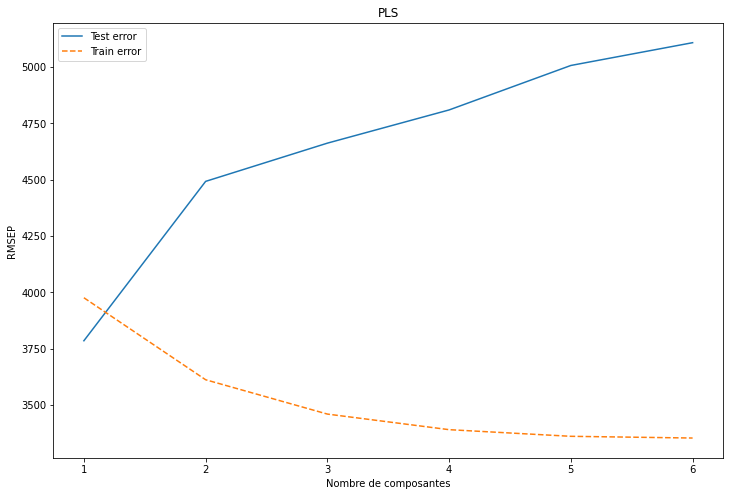

In [162]:
plt.plot(error_test_pls.keys(), error_test_pls.values(), label="Test error")
plt.plot(error_train_pls.keys(), error_train_pls.values(), ls="--", label="Train error")
plt.xlabel("Nombre de composantes")
plt.ylabel("RMSEP")
plt.title("PLS")
plt.legend()
plt.show()

Le critère est minimal (3785.33) pour 1 composante. On apprend désormais le modèle.

In [170]:
n_comp = 1
pls[n_comp].fit(X, y)

PLSRegression(n_components=1)

In [178]:
pls[n_comp].coef_

array([[ 958.03905452],
       [1198.25986571],
       [ 965.80401707],
       [ 820.11735637],
       [1130.13961394],
       [ 872.79198926]])

#### Régression Ridge

Pour la régression ridge, scikit-learn dispose de 2 fonctions : Ridge et RidgeCV. La 1ère apprend une ridge pour une seule valeur de l'hyperparamètre tandis que RidgeCV permet de faire de la validation croisée pour choisir la meilleure valeur parmi un ensemble de valeurs. On notera qu'on laisse la méthode de validation croisée par défaut, car dans le cas de la régression ridge, il existe une formule exacte pour le score leave-one-out qui est calculé de base de manière optimisée. À noter que RidgeCV ne propose pas d'heuristique pour choisir les valeurs d'alpha.

In [185]:
ridge = RidgeCV(alphas=np.arange(0.1, 100000, 1), store_cv_values=True)
ridge.fit(X, y)

RidgeCV(alphas=array([1.00000e-01, 1.10000e+00, 2.10000e+00, ..., 9.99971e+04,
       9.99981e+04, 9.99991e+04]),
        store_cv_values=True)

Le paramètre optimal est :

In [197]:
ridge.alpha_

19310.1

In [205]:
ridge.cv_values_.shape

(18, 100000)

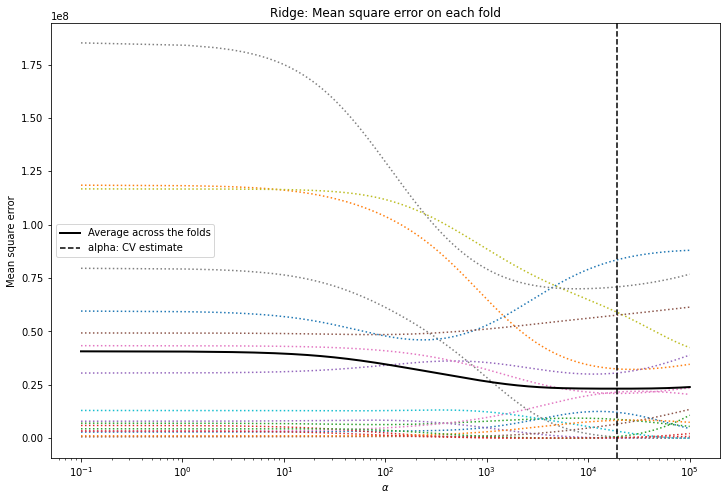

In [212]:
plt.figure()
plt.semilogx(ridge.alphas, ridge.cv_values_.T, ":")
plt.plot(ridge.alphas, ridge.cv_values_.mean(axis=0), "black",
         label="Average across the folds", linewidth=2)
plt.axvline(ridge.alpha_, linestyle="--", color="black",
            label="alpha: CV estimate")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title("Ridge: Mean square error on each fold")
plt.show()

In [222]:
ridge_best = Ridge(alpha=ridge.alpha_)
ridge_best.fit(X, y)

Ridge(alpha=19310.1)

La valeur de RMSEP pour notre modèle ridge est :

In [230]:
-cross_val_score(ridge_best, X, y, cv=n, scoring="neg_root_mean_squared_error").mean()

3878.533138865312

In [241]:
ridge_best.coef_

array([ 2.35223883, 21.75905149,  1.92321203,  0.59702154, 26.27356241,
       10.62928607])

In [248]:
ridge_best.intercept_

-2480.9067955354258

#### Lasso

Comme pour la ridge, le lasso dispose de 2 fonctions. Au contraire de la ridge, nous précisons, le nombre de folds de la validation croisée car il n'y a pas de formule exacte pour le critère de leave-one-out. Le lasso dispose d'une heuristique pour le choix d'une gamme de valeur à tester, nous n'en fournissons donc pas.

In [259]:
lasso = LassoCV(cv=n)
lasso.fit(X, y)

LassoCV(cv=18)

Liste des valeurs des testées

In [268]:
lasso.alphas_

array([1482013.98148148, 1382131.19925736, 1288980.18225913,
       1202107.23204101, 1121089.22791397, 1045531.56610729,
        975066.23782371,  909350.03682722,  848062.88783345,
        790906.28756092,  737601.8508503 ,  687889.95477025,
        641528.47410608,  598291.60207221,  557968.75050467,
        520363.5241769 ,  485292.76424333,  452585.65615154,
        422082.89767826,  393635.92303691,  367106.17927769,
        342364.45145589,  319290.2332816 ,  297771.14018554,
        277702.36194227,  258986.15218473,  241531.35232389,
        225252.94755449,  210071.65278463,  195913.52647223,
        182709.6104877 ,  170395.59424856,  158911.50149036,
        148201.39814815,  138213.11992574,  128898.01822591,
        120210.7232041 ,  112108.9227914 ,  104553.15661073,
         97506.62378237,   90935.00368272,   84806.28878334,
         79090.62875609,   73760.18508503,   68788.99547702,
         64152.84741061,   59829.16020722,   55796.87505047,
         52036.35241769,

Valeur choisie par validation croisée

In [277]:
lasso.alpha_

8480.628878334483

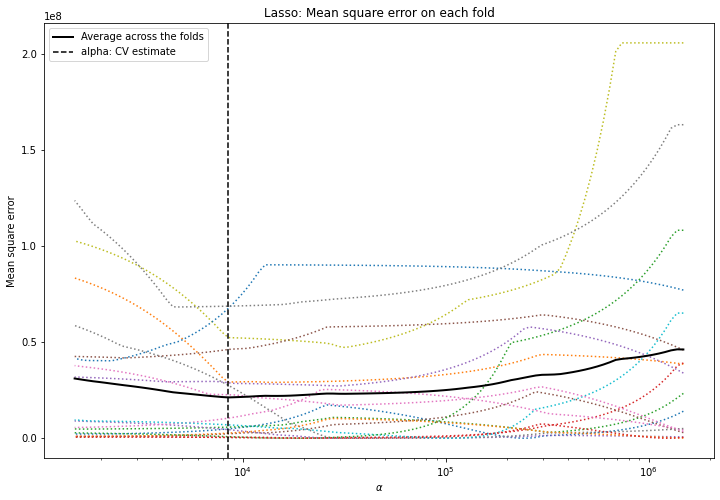

In [289]:
plt.figure()
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1), "black",
         label="Average across the folds", linewidth=2)
plt.axvline(lasso.alpha_, linestyle="--", color="black",
            label="alpha: CV estimate")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title("Lasso: Mean square error on each fold")
plt.show()

In [301]:
lasso_best = Lasso(alpha=lasso.alpha_)
lasso_best.fit(X, y)

Lasso(alpha=8480.628878334483)

Le RMSEP pour le lasso est :

In [312]:
-cross_val_score(lasso_best, X, y, cv=n, scoring="neg_root_mean_squared_error").mean()

3848.1520132325336

In [323]:
lasso_best.coef_

array([ -1.22499179, 137.0840401 ,   0.        ,   0.        ,
        22.69673652,   0.        ])

In [333]:
X.columns[lasso_best.coef_ != 0]

Index(['CYL', 'PUIS', 'POIDS'], dtype='object')

In [349]:
lasso_best.intercept_

72.56051922932966